In [4]:
import tensorflow as tf
import json
import numpy as np
import pandas as pd

from google.cloud import bigquery
from google.cloud import storage

from google.cloud import aiplatform


import matplotlib.pyplot as plt
import seaborn as sns
#https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/custom/custom-tabular-bq-managed-dataset.ipynb

In [5]:
print(tf.__version__)

2.11.0


In [6]:
#table_id='new_incident'
table_id='test_incident'
# table_id='validation_incident'

projectId='smart-data-ml'
dataset_id='SMartML'
REGION="asia-southeast1"

if  table_id=='new_incident':
 unUsedColtoPredict=['severity','id','severity_id','severity_name','imported_at']
 filePath='../../data/Prediction_New_Incident.csv'
elif table_id=='test_incident' or table_id=='validation_incident':
 unUsedColtoPredict=['severity','id','severity_id','severity_name']  
 filePath=f'../../data/Prediction_{table_id}.csv'
    
isLocalModel=True

isBQToCSV=False


modelFile_endPoint=1 
#1=local(dev)/gcs(clound function) and 2=vertext

localFile=True


In [7]:
from google.oauth2 import service_account
mycredentials = service_account.Credentials.from_service_account_file(r'C:\Windows\smart-data-ml-91b6f6204773.json')

if isBQToCSV:
    
    
    bqclient= bigquery.Client(project=projectId,credentials=mycredentials)
    def download_table(bq_table_uri: str):

        prefix = "bq://"
        if bq_table_uri.startswith(prefix):
            bq_table_uri = bq_table_uri[len(prefix) :]

        table = bigquery.TableReference.from_string(bq_table_uri)
        rows = bqclient.list_rows(table)
        return rows.to_dataframe()

    dfNewData=download_table(f"{projectId}.{dataset_id}.{table_id}")
    dfNewData.to_csv(filePath,index=False)    
    print(dfNewData.info())


# Load and Map Data Test

In [8]:
if  localFile:
    dfNewData=pd.read_csv(filePath)

# dfNewData=dfNewData.sample(3)

In [9]:
mapping_file="incident_sevirity_to_class.json"

def download_map_severity_class_as_dict():
 
    storage_client = storage.Client()
    buckdfNewData = storage_client.bucket("smart-ml-pongthorn")
    blob = bucket.blob(mapping_file)
    blob.download_to_filename(mapping_file)
    with open(mapping_file, 'r') as file:
            return json.loads(file.read())

if  localFile==False:    
    map_sevirity_to_class= download_map_severity_class_as_dict()
else:
   with open(mapping_file, 'r') as json_file:
     map_sevirity_to_class= json.load(json_file)
                                  
                                  
print(map_sevirity_to_class)


{'Cosmatic': 0, 'Minor': 1, 'Major': 2, 'Critical': 3}


In [10]:
if table_id=='new_incident':
    
    dfNewData.insert(2, 'severity', dfNewData['severity_name'].map(map_sevirity_to_class),True)
    print(dfNewData.info())
elif table_id=='test_incident' or table_id=='validation_incident':
    
    dfNewData=dfNewData.rename(columns={'label_multi_severity':'severity'})
    dfNewData=dfNewData.drop(columns=['label_binary_severity'])
    if 'id' not in dfNewData.columns.to_list():
        dfNewData=dfNewData.reset_index(drop=True)
        dfNewData = dfNewData.reset_index(level=0)
        dfNewData.rename(columns={"index": "id"},inplace=True)
        dfNewData['id']=dfNewData['id']+1
print(filePath)      
dfNewData.tail()

../../data/Prediction_test_incident.csv


,id,severity_id,severity_name,sla,product_type,brand,service_type,incident_type,open_to_close_hour,response_to_resolved_hour,severity
212,213,2,Major,24x7 4Hrs Resolution Time,Access Point,Cisco,Incident,General Incident,1.000000,1.000000,2
213,214,3,Minor,24x7 4Hrs Resolution Time,Access Point,Cisco,Incident,General Incident,27.000000,24.033333,1
214,215,4,Cosmatic,24x7 4Hrs Resolution Time,Access Point,Cisco,Request,Configuration Change,0.500000,0.500000,0
215,216,2,Major,24x7 4Hrs Resolution Time,Tape Library,DELL,Incident,General Incident,1.133333,1.000000,2
216,217,4,Cosmatic,24x7 4Hrs Resolution Time,Tape Library,Oracle,Request,Report,2.000000,2.000000,0


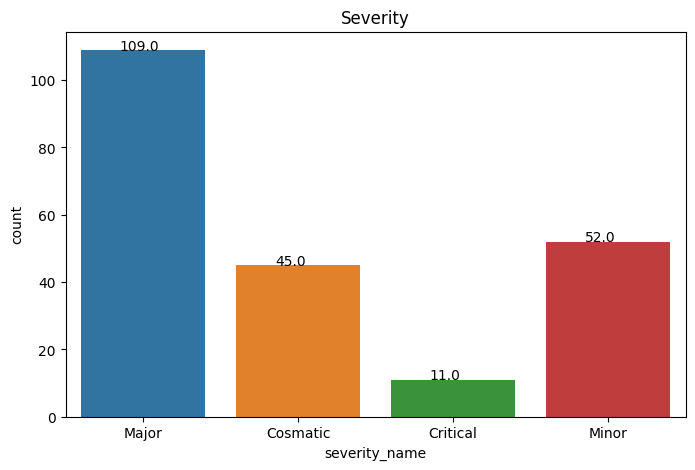

In [11]:
def plot_class(df):
    fig , ax = plt.subplots(figsize=(8,5))
    ax =sns.countplot(x='severity_name', data=df,)
    for p in ax.patches:
       ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
    plt.title('Severity')
    plt.show()
    
plot_class(dfNewData)

In [12]:
pdPrediction=pd.DataFrame(columns=['_id','_predict_severity'])
pdPrediction

,_id,_predict_severity


# Load Model from Directory to Predict

In [13]:
if modelFile_endPoint==1 :

    if  isLocalModel: # Window Enviroment
        PATH_FOLDER_ARTIFACTS="model"    
    else: # For running on Vertex AI Notebook t
        PATH_FOLDER_ARTIFACTS="gs://tf1-incident-pongthorn/model"

    model = tf.keras.models.load_model(PATH_FOLDER_ARTIFACTS)    
    print(f"Load from {PATH_FOLDER_ARTIFACTS}")
    # model.summary()

    
    for  row_dict in dfNewData.to_dict(orient="records"):
          incident_id=row_dict['id']
          print(f"{incident_id} - {row_dict['severity']}({row_dict['severity_name']})") 
          for key_removed in unUsedColtoPredict:
           row_dict.pop(key_removed)
          # print(row_dict)  

          input_dict = {name: tf.convert_to_tensor([value]) for name, value in row_dict.items()}


          predictionResult = model.predict(input_dict)
          # print(f"{predictionResult}")   
          # maxResult=np.max(arryResult)
          # maxResult=round( maxResult,4)
          # print(f"{maxResult} of {arryResult}")

          prob = tf.nn.softmax(predictionResult)
          prob_pct=(100 * prob)  
          _class = tf.argmax(predictionResult,-1).numpy()[0]
          
          pdPrediction =pd.concat([pdPrediction,pd.DataFrame.from_dict([{'_id':incident_id, '_predict_severity':_class}])] )
          # print(input_dict)  
            
          print(f"{prob_pct} %   as {_class}")     
          print("======================================================================================")

    dfPredictData=pd.merge(dfNewData,pdPrediction,how='inner',left_on='id',right_on='_id')
    dfPredictData=dfPredictData.drop(columns=['_id'])
    dfPredictData=dfPredictData[['id','_predict_severity','severity','severity_name']]


Load from model
1 - 2(Major)
1/1 [==============================] - 0s 445ms/step
[[18.855038 24.310122 37.972553 18.862291]] %   as 2
2 - 2(Major)
1/1 [==============================] - 0s 42ms/step
[[19.094805 34.933765 25.319866 20.651567]] %   as 1
3 - 2(Major)
1/1 [==============================] - 0s 46ms/step
[[18.393166 21.40462  41.8428   18.359417]] %   as 2
4 - 0(Cosmatic)
1/1 [==============================] - 0s 45ms/step
[[30.324295 30.985542 19.718624 18.971533]] %   as 1
5 - 3(Critical)
1/1 [==============================] - 0s 47ms/step
[[19.365429 22.801954 32.21396  25.618654]] %   as 2
6 - 3(Critical)
1/1 [==============================] - 0s 47ms/step
[[19.372957 22.868185 32.008327 25.750532]] %   as 2
7 - 3(Critical)
1/1 [==============================] - 0s 46ms/step
[[18.590403 22.008936 40.845856 18.554806]] %   as 2
8 - 3(Critical)
1/1 [==============================] - 0s 45ms/step
[[19.382149 22.93753  31.84599  25.834337]] %   as 2
9 - 3(Critical)
1/1 [===

# Registry and Deploy Model to VertextAI
- https://cloud.google.com/vertex-ai/docs/predictions/get-predictions#deploy_a_model_to_an_endpoint


## Load Model from Online EndPpint to Predict
- https://cloud.google.com/vertex-ai/docs/tabular-data/classification-regression/get-online-predictions
- https://cloud.google.com/vertex-ai/docs/tutorials/tabular-bq-prediction/train-and-deploy-model
- https://cloud.google.com/vertex-ai/docs/tutorials/tabular-bq-prediction/make-prediction

In [14]:
#https://console.cloud.google.com/vertex-ai/endpoints?project=pongthorn
#https://console.cloud.google.com/vertex-ai/batch-predictions?project=pongthorn


# MODEL_ID="2102389377610022912"
# MODEL_URI =  f'projects/{PROJECT_NUMBER}/locations/{REGION}/models/{MODEL_ID}'
# print(MODEL_URI)

# model = aiplatform.Model(MODEL_URI)

# Load model by refering to vertext-ai registry

In [15]:
# instances = []
# dfX=dfNewData.drop(columns=unUsedColtoPredict)
# for index,row in dfX.iterrows():
#     dict_item=row.to_dict()
#     instance = {}
#     for key, value in dict_item.items():
#         if key in unUsedColtoPredict:
#             continue
#         if value is None:
#             value = ""
#         instance[key] = [value]
#         # instance[key] = value
#     instances.append(instance)

# print(len(instances))
# print(instances[0])

In [16]:
isEndpointAvaiable=False

listRequestData=[]
try:
    ENDPOINT_ID="2704182877817405440"
    endpoint = aiplatform.Endpoint(endpoint_name=f"projects/{projectId}/locations/{REGION}/endpoints/{ENDPOINT_ID}"
                                   ,credentials=mycredentials)
    print(endpoint)
    isEndpointAvaiable=True
except Exception as error:
    print(str(error))
    
if modelFile_endPoint==2 and isEndpointAvaiable==True :

    for data in dfNewData.to_dict(orient="records"):
        incident_id=data['id']
        severity=data['severity']
        severity_name=data['severity_name']
        # convert dict to tf format
        request_data = {key : [value] for key,value in data.items() }
        for key_removed in unUsedColtoPredict:
           request_data.pop(key_removed)
        listRequestData.append(request_data)
        print(request_data)

        response = endpoint.predict([request_data])
        y_predicted = np.argmax(response.predictions, axis=1)
        predictionResult=response[0][0]
        print(predictionResult)
        print(y_predicted)

        pdPrediction =pd.concat([pdPrediction,pd.DataFrame.from_dict([{'_id':incident_id, '_predict_severity':y_predicted[0]}])] )
        print("======================================================================================")

    dfPredictData=pd.merge(dfNewData,pdPrediction,how='inner',left_on='id',right_on='_id')
    dfPredictData=dfPredictData.drop(columns=['_id'])
    dfPredictData=dfPredictData[['id','_predict_severity','severity','severity_name']]       
else:
     print("No endpoint to predict  as online predction")     

404 Endpoint projects/smart-data-ml/locations/asia-southeast1/endpoints/2704182877817405440 is not found.
No endpoint to predict  as online predction


# Classification Rerport

In [17]:
from sklearn.metrics import confusion_matrix,classification_report


In [18]:
dfPredictData

,id,_predict_severity,severity,severity_name
0,1,2,2,Major
1,2,1,2,Major
2,3,2,2,Major
3,4,1,0,Cosmatic
4,5,2,3,Critical
...,...,...,...,...
212,213,2,2,Major
213,214,2,1,Minor
214,215,0,0,Cosmatic
215,216,1,2,Major


In [19]:
className=list(set().union(list(dfPredictData['severity'].unique()),list(dfPredictData['_predict_severity'].unique())))
actualClass=[  f'actual-{x}' for x in  className]
predictedlClass=[  f'predcited-{x}' for x in className]

y_true=list(dfPredictData['severity'])
y_pred=list(dfPredictData['_predict_severity'])
cnf_matrix = confusion_matrix(y_true,y_pred)
cnf_matrix

# #index=actual , column=prediction
cm_df = pd.DataFrame(cnf_matrix,
                     index = actualClass, 
                     columns = predictedlClass)
cm_df

,predcited-0,predcited-1,predcited-2,predcited-3
actual-0,38,5,2,0
actual-1,0,28,24,0
actual-2,0,7,102,0
actual-3,0,1,10,0


In [20]:
print(classification_report(y_true, y_pred, labels=className))

              precision    recall  f1-score   support

           0       1.00      0.84      0.92        45
           1       0.68      0.54      0.60        52
           2       0.74      0.94      0.83       109
           3       0.00      0.00      0.00        11

    accuracy                           0.77       217
   macro avg       0.61      0.58      0.59       217
weighted avg       0.74      0.77      0.75       217



D:\ProgramData\Anaconda3\envs\dev_google\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ProgramData\Anaconda3\envs\dev_google\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ProgramData\Anaconda3\envs\dev_google\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
